# Recurrent Neural Network (RNN) from Scratch

## Project Overview
This notebook implements a **time series forecasting** model using a Recurrent Neural Network built entirely from scratch. We use the **book_sales.csv** dataset to predict future book sales based on historical patterns.

### Dataset
- **Source**: book_sales.csv
- **Features**: Date, Paperback sales, Hardcover sales
- **Task**: Time series prediction of book sales

### Why RNN for Time Series?
Unlike traditional neural networks, RNNs can **remember previous information** through hidden states, making them perfect for sequential data. Each time step's output depends on both current input and previous hidden state, allowing the network to capture temporal dependencies.

## Installation & Imports

In [2]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Exploration

In [3]:
# Load the book sales dataset
data = pd.read_csv("book_sales.csv")
print("Dataset Shape:", data.shape)
print("\nFirst 10 rows:")
print(data.head(10))
print("\nDataset Info:")
print(data.info())
print("\nStatistical Summary:")
print(data.describe())

Dataset Shape: (30, 3)

First 10 rows:
         Date  Paperback  Hardcover
0  2000-04-01        199        139
1  2000-04-02        172        128
2  2000-04-03        111        172
3  2000-04-04        209        139
4  2000-04-05        161        191
5  2000-04-06        119        168
6  2000-04-07        195        170
7  2000-04-08        195        145
8  2000-04-09        131        184
9  2000-04-10        183        135

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       30 non-null     object
 1   Paperback  30 non-null     int64 
 2   Hardcover  30 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 852.0+ bytes
None

Statistical Summary:
        Paperback   Hardcover
count   30.000000   30.000000
mean   186.400000  198.833333
std     35.480543   40.301522
min    111.000000  128.000000
25%    167.250000  17

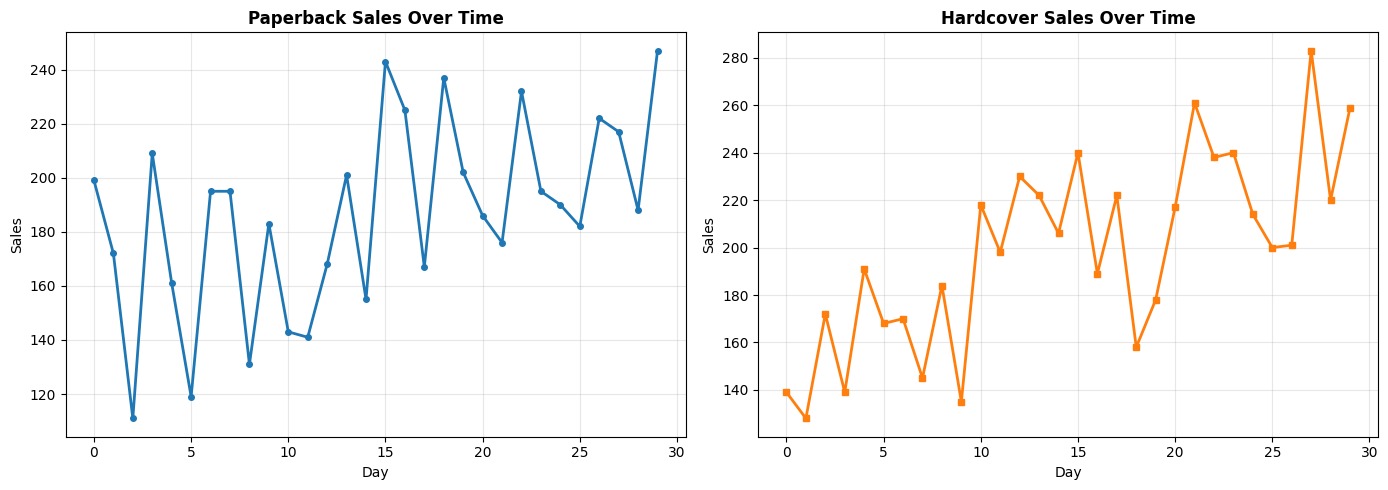

In [4]:
# Visualize the raw data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Paperback sales
axes[0].plot(data.index, data['Paperback'], marker='o', linewidth=2, color='#1f77b4', markersize=4)
axes[0].set_title('Paperback Sales Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Sales')
axes[0].grid(True, alpha=0.3)

# Plot Hardcover sales
axes[1].plot(data.index, data['Hardcover'], marker='s', linewidth=2, color='#ff7f0e', markersize=4)
axes[1].set_title('Hardcover Sales Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Sales')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Data Preprocessing

### Sequence Preparation for RNN
For time series prediction, we need to create sequences where:
- **Input (X)**: Previous `time_steps` values
- **Output (Y)**: Next value to predict

Example with time_steps=3:
- X = [day1, day2, day3] → Y = [day4]
- X = [day2, day3, day4] → Y = [day5]

In [5]:
# Select target variable (we'll predict Paperback sales)
sales_data = data['Paperback'].values.reshape(-1, 1)

# Normalize the data to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_data)

print("Original data shape:", sales_data.shape)
print("Scaled data range: [{:.3f}, {:.3f}]".format(scaled_data.min(), scaled_data.max()))

Original data shape: (30, 1)
Scaled data range: [0.000, 1.000]


In [6]:
def create_sequences(data, time_steps=5):
    """
    Create sequences for time series prediction.
    
    Parameters:
    - data: Normalized time series data
    - time_steps: Number of previous time steps to use as input
    
    Returns:
    - X: Input sequences (samples, time_steps, features)
    - Y: Target values (samples, 1)
    """
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        Y.append(data[i + time_steps])
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Create sequences with 5 time steps
time_steps = 5
X, Y = create_sequences(scaled_data, time_steps)

print("Sequence shapes:")
print(f"X (input sequences): {X.shape}")  # (samples, time_steps, features)
print(f"Y (targets): {Y.shape}")         # (samples, 1)

# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Sequence shapes:
X (input sequences): (25, 5, 1)
Y (targets): (25, 1)

Train set: 20 samples
Test set: 5 samples


## RNN Implementation from Scratch

### Architecture Overview
Our RNN will have:
1. **Input Layer**: Takes sequences of sales data
2. **Hidden Layer 1**: First recurrent layer with tanh activation
3. **Hidden Layer 2**: Second recurrent layer with tanh activation
4. **Output Layer**: Linear layer for regression
5. **Backpropagation Through Time (BPTT)**: Updates weights across all time steps

In [7]:
class RNN:
    """
    Recurrent Neural Network with 2 hidden layers for time series prediction.
    
    Architecture:
    - Input → Hidden Layer 1 (Recurrent) → Hidden Layer 2 (Recurrent) → Output
    - Uses tanh activation for hidden layers
    - Implements Backpropagation Through Time (BPTT)
    """
    
    def __init__(self, input_size=1, hidden1_size=32, hidden2_size=16, output_size=1, learning_rate=0.001):
        """
        Initialize RNN with random weights.
        
        Parameters:
        - input_size: Dimension of input at each time step (default: 1)
        - hidden1_size: Number of neurons in first hidden layer
        - hidden2_size: Number of neurons in second hidden layer
        - output_size: Dimension of output (default: 1)
        - learning_rate: Learning rate for gradient descent
        """
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights for Hidden Layer 1
        self.Wxh1 = np.random.randn(input_size, hidden1_size) * 0.01
        self.Whh1 = np.random.randn(hidden1_size, hidden1_size) * 0.01
        self.bh1 = np.zeros((1, hidden1_size))
        
        # Initialize weights for Hidden Layer 2
        self.Wh1h2 = np.random.randn(hidden1_size, hidden2_size) * 0.01
        self.Whh2 = np.random.randn(hidden2_size, hidden2_size) * 0.01
        self.bh2 = np.zeros((1, hidden2_size))
        
        # Initialize weights for Output Layer
        self.Why = np.random.randn(hidden2_size, output_size) * 0.01
        self.by = np.zeros((1, output_size))
        
        # Track loss history
        self.loss_history = []
        
    def tanh(self, x):
        """Hyperbolic tangent activation function"""
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        """Derivative of tanh for backpropagation"""
        return 1 - np.tanh(x) ** 2
    
    def forward_propagation(self, X):
        """
        Forward pass through the RNN for a single sequence.
        
        Parameters:
        - X: Input sequence of shape (time_steps, input_size)
        
        Returns:
        - y_pred: Predicted output
        - cache: Dictionary containing intermediate values for backprop
        """
        time_steps = X.shape[0]
        
        # Initialize hidden states
        h1 = np.zeros((time_steps + 1, self.hidden1_size))
        h2 = np.zeros((time_steps + 1, self.hidden2_size))
        
        # Store pre-activation values for backprop
        z1 = np.zeros((time_steps, self.hidden1_size))
        z2 = np.zeros((time_steps, self.hidden2_size))
        
        # Forward pass through time
        for t in range(time_steps):
            # Hidden Layer 1: h1[t] = tanh(Wxh1 * x[t] + Whh1 * h1[t-1] + bh1)
            z1[t] = np.dot(X[t:t+1], self.Wxh1) + np.dot(h1[t:t+1], self.Whh1) + self.bh1
            h1[t+1] = self.tanh(z1[t])
            
            # Hidden Layer 2: h2[t] = tanh(Wh1h2 * h1[t] + Whh2 * h2[t-1] + bh2)
            z2[t] = np.dot(h1[t+1:t+2], self.Wh1h2) + np.dot(h2[t:t+1], self.Whh2) + self.bh2
            h2[t+1] = self.tanh(z2[t])
        
        # Output: y = Why * h2[T] + by (use last hidden state)
        y_pred = np.dot(h2[time_steps:time_steps+1], self.Why) + self.by
        
        # Cache for backpropagation
        cache = {'X': X, 'h1': h1, 'h2': h2, 'z1': z1, 'z2': z2, 'y_pred': y_pred}
        
        return y_pred, cache
    
    def backward_propagation(self, cache, y_true):
        """
        Backpropagation Through Time (BPTT).
        
        Parameters:
        - cache: Dictionary from forward pass
        - y_true: True target value
        
        Returns:
        - gradients: Dictionary containing all weight gradients
        """
        X = cache['X']
        h1 = cache['h1']
        h2 = cache['h2']
        z1 = cache['z1']
        z2 = cache['z2']
        y_pred = cache['y_pred']
        
        time_steps = X.shape[0]
        
        # Initialize gradients
        dWxh1 = np.zeros_like(self.Wxh1)
        dWhh1 = np.zeros_like(self.Whh1)
        dbh1 = np.zeros_like(self.bh1)
        
        dWh1h2 = np.zeros_like(self.Wh1h2)
        dWhh2 = np.zeros_like(self.Whh2)
        dbh2 = np.zeros_like(self.bh2)
        
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        
        # Output layer gradient (MSE loss derivative)
        dy = y_pred - y_true
        
        # Gradient for output weights
        dWhy = np.dot(h2[time_steps:time_steps+1].T, dy)
        dby = dy
        
        # Backpropagate to hidden layer 2
        dh2_next = np.zeros((1, self.hidden2_size))
        dh1_next = np.zeros((1, self.hidden1_size))
        
        # Gradient from output to last hidden state
        dh2 = np.dot(dy, self.Why.T)
        
        # Backpropagate through time
        for t in reversed(range(time_steps)):
            # Add gradient from next time step
            dh2 = dh2 + dh2_next
            
            # Gradient through tanh activation (hidden layer 2)
            dz2 = dh2 * self.tanh_derivative(z2[t])
            
            # Accumulate gradients for hidden layer 2
            dWh1h2 += np.dot(h1[t+1:t+2].T, dz2)
            dWhh2 += np.dot(h2[t:t+1].T, dz2)
            dbh2 += dz2
            
            # Gradient flowing to hidden layer 1
            dh1 = np.dot(dz2, self.Wh1h2.T) + dh1_next
            
            # Gradient through tanh activation (hidden layer 1)
            dz1 = dh1 * self.tanh_derivative(z1[t])
            
            # Accumulate gradients for hidden layer 1
            dWxh1 += np.dot(X[t:t+1].T, dz1)
            dWhh1 += np.dot(h1[t:t+1].T, dz1)
            dbh1 += dz1
            
            # Prepare gradients for next time step (going backward)
            dh2_next = np.dot(dz2, self.Whh2.T)
            dh1_next = np.dot(dz1, self.Whh1.T)
        
        gradients = {
            'dWxh1': dWxh1, 'dWhh1': dWhh1, 'dbh1': dbh1,
            'dWh1h2': dWh1h2, 'dWhh2': dWhh2, 'dbh2': dbh2,
            'dWhy': dWhy, 'dby': dby
        }
        
        return gradients
    
    def update_weights(self, gradients):
        """Update weights using gradient descent."""
        # Clip gradients to prevent exploding gradients
        max_grad = 5.0
        for key in gradients:
            np.clip(gradients[key], -max_grad, max_grad, out=gradients[key])
        
        # Update weights
        self.Wxh1 -= self.learning_rate * gradients['dWxh1']
        self.Whh1 -= self.learning_rate * gradients['dWhh1']
        self.bh1 -= self.learning_rate * gradients['dbh1']
        
        self.Wh1h2 -= self.learning_rate * gradients['dWh1h2']
        self.Whh2 -= self.learning_rate * gradients['dWhh2']
        self.bh2 -= self.learning_rate * gradients['dbh2']
        
        self.Why -= self.learning_rate * gradients['dWhy']
        self.by -= self.learning_rate * gradients['dby']
    
    def train(self, X_train, Y_train, epochs=100):
        """Train the RNN model."""
        num_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            total_loss = 0
            
            # Train on each sequence
            for i in range(num_samples):
                # Forward pass
                y_pred, cache = self.forward_propagation(X_train[i])
                
                # Compute loss (MSE)
                loss = np.mean((y_pred - Y_train[i]) ** 2)
                total_loss += loss
                
                # Backward pass
                gradients = self.backward_propagation(cache, Y_train[i])
                
                # Update weights
                self.update_weights(gradients)
            
            # Average loss for this epoch
            avg_loss = total_loss / num_samples
            self.loss_history.append(avg_loss)
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")
    
    def predict(self, X):
        """Make predictions for input sequences."""
        predictions = []
        for i in range(X.shape[0]):
            y_pred, _ = self.forward_propagation(X[i])
            predictions.append(y_pred[0, 0])
        
        return np.array(predictions).reshape(-1, 1)

print("✓ RNN model with 2 hidden layers defined and ready for training!")

✓ RNN model with 2 hidden layers defined and ready for training!


## Model Training

In [8]:
# Initialize RNN with 2 hidden layers
print("Training RNN Model...")
print("="*60)

model = RNN(
    input_size=1,          # Single feature (sales value)
    hidden1_size=32,       # First hidden layer with 32 neurons
    hidden2_size=16,       # Second hidden layer with 16 neurons
    output_size=1,         # Single output (predicted sales)
    learning_rate=0.001    # Learning rate
)

# Train the model
model.train(X_train, Y_train, epochs=100)

print("="*60)
print("✓ Training Complete!")

Training RNN Model...
Epoch 10/100, Loss: 0.260734
Epoch 20/100, Loss: 0.195027
Epoch 30/100, Loss: 0.151082
Epoch 40/100, Loss: 0.121705
Epoch 50/100, Loss: 0.102084
Epoch 60/100, Loss: 0.088992
Epoch 70/100, Loss: 0.080269
Epoch 80/100, Loss: 0.074464
Epoch 90/100, Loss: 0.070607
Epoch 100/100, Loss: 0.068047
✓ Training Complete!


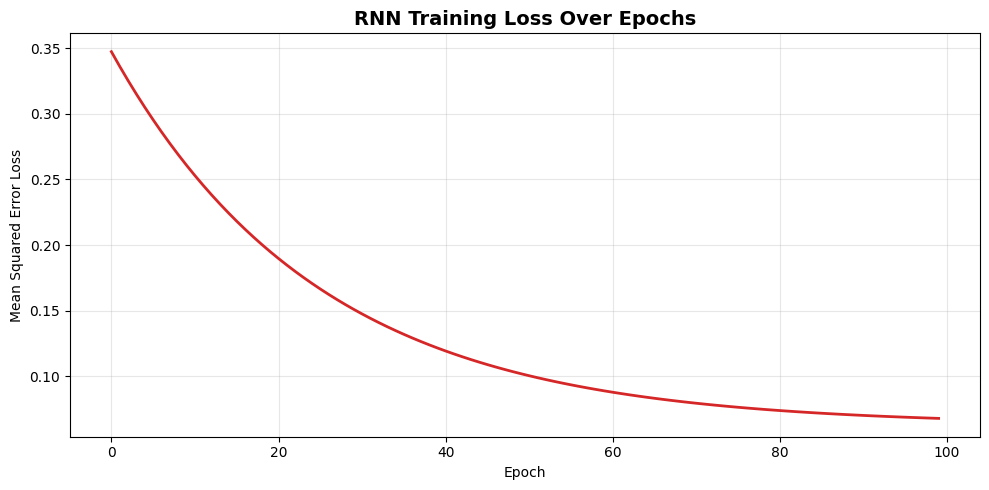

Initial Loss: 0.347289
Final Loss: 0.068047
Loss Reduction: 80.41%


In [9]:
# Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(model.loss_history, linewidth=2, color='#d62728')
plt.title('RNN Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Loss: {model.loss_history[0]:.6f}")
print(f"Final Loss: {model.loss_history[-1]:.6f}")
print(f"Loss Reduction: {((model.loss_history[0] - model.loss_history[-1]) / model.loss_history[0] * 100):.2f}%")

## Model Evaluation & Predictions

In [10]:
# Make predictions on train and test sets
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Inverse transform to get actual sales values
Y_train_actual = scaler.inverse_transform(Y_train)
Y_train_pred_actual = scaler.inverse_transform(Y_train_pred)

Y_test_actual = scaler.inverse_transform(Y_test)
Y_test_pred_actual = scaler.inverse_transform(Y_test_pred)

# Calculate evaluation metrics for test set
mse = mean_squared_error(Y_test_actual, Y_test_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_actual, Y_test_pred_actual)
r2 = r2_score(Y_test_actual, Y_test_pred_actual)
mape = np.mean(np.abs((Y_test_actual - Y_test_pred_actual) / Y_test_actual)) * 100

print("\n" + "=" * 60)
print("TEST SET EVALUATION METRICS")
print("=" * 60)
print(f"Mean Squared Error (MSE):      {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE):      {mae:.2f}")
print(f"R² Score:                       {r2:.4f}")
print(f"Mean Absolute % Error (MAPE):   {mape:.2f}%")
print("=" * 60)


TEST SET EVALUATION METRICS
Mean Squared Error (MSE):      1896.50
Root Mean Squared Error (RMSE): 43.55
Mean Absolute Error (MAE):      36.50
R² Score:                       -2.3593
Mean Absolute % Error (MAPE):   16.23%


## Comprehensive Visualization of Results

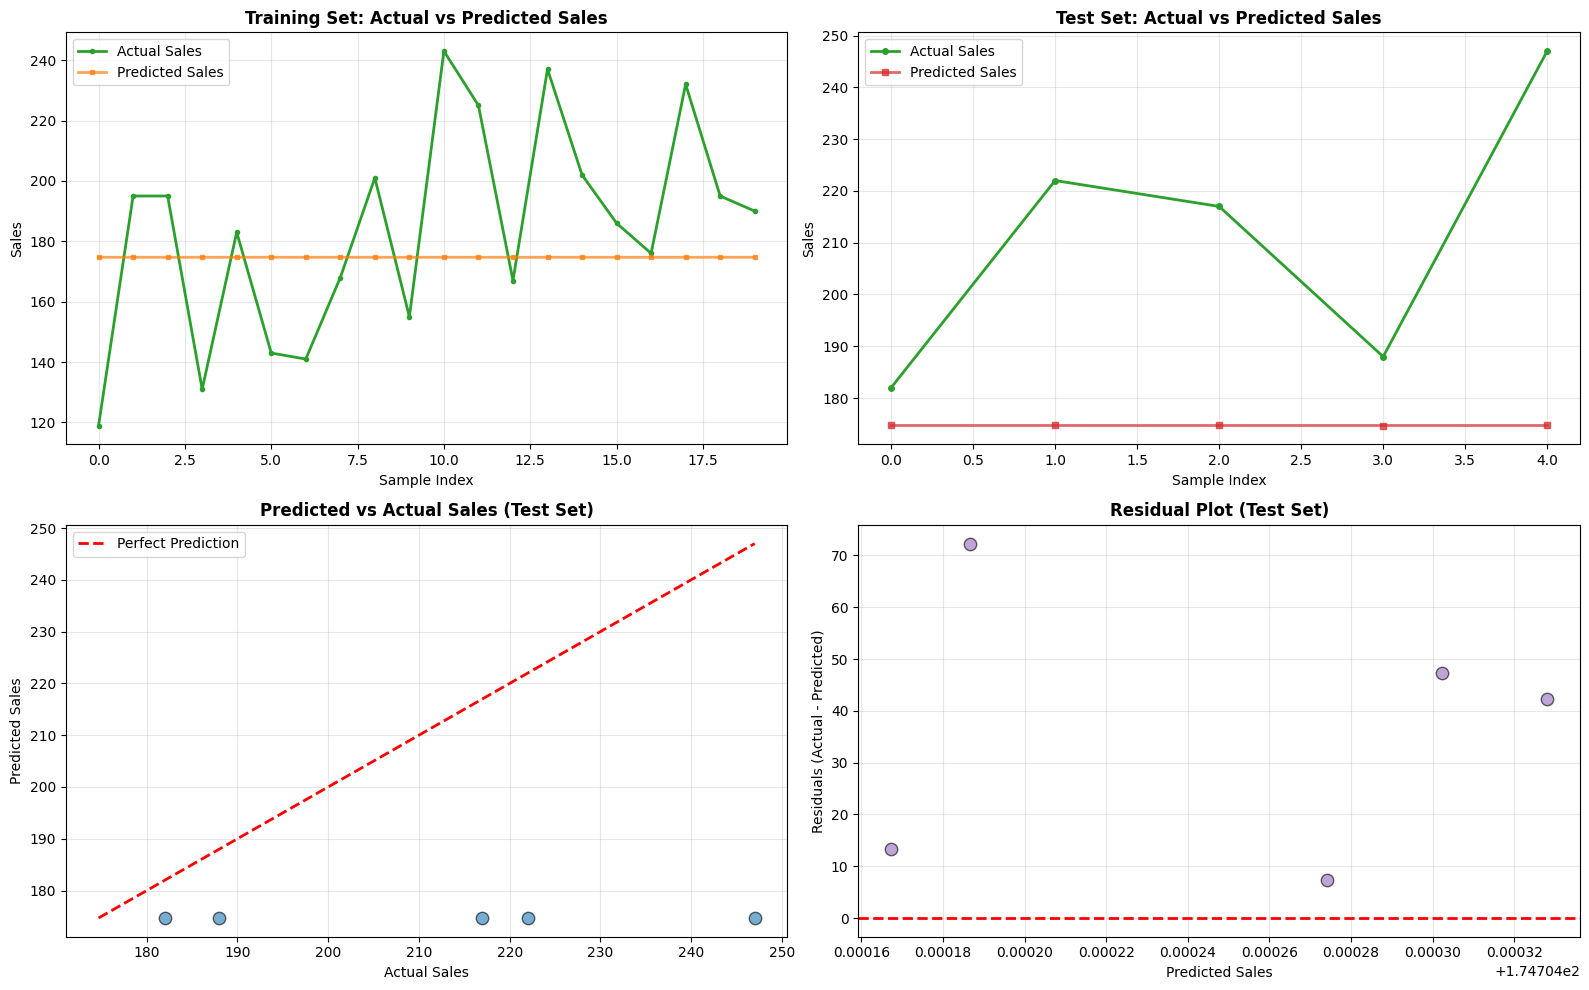

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Train vs Predicted (Training Set)
axes[0, 0].plot(Y_train_actual, label='Actual Sales', color='#2ca02c', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(Y_train_pred_actual, label='Predicted Sales', color='#ff7f0e', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 0].set_title('Training Set: Actual vs Predicted Sales', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Test vs Predicted (Test Set)
axes[0, 1].plot(Y_test_actual, label='Actual Sales', color='#2ca02c', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(Y_test_pred_actual, label='Predicted Sales', color='#d62728', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[0, 1].set_title('Test Set: Actual vs Predicted Sales', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter Plot: Predicted vs Actual
axes[1, 0].scatter(Y_test_actual, Y_test_pred_actual, alpha=0.6, color='#1f77b4', edgecolor='black', s=80)
# Perfect prediction line
min_val = min(Y_test_actual.min(), Y_test_pred_actual.min())
max_val = max(Y_test_actual.max(), Y_test_pred_actual.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Predicted vs Actual Sales (Test Set)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Sales')
axes[1, 0].set_ylabel('Predicted Sales')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual Plot
residuals = Y_test_actual - Y_test_pred_actual
axes[1, 1].scatter(Y_test_pred_actual, residuals, alpha=0.6, color='#9467bd', edgecolor='black', s=80)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Plot (Test Set)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Sales')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

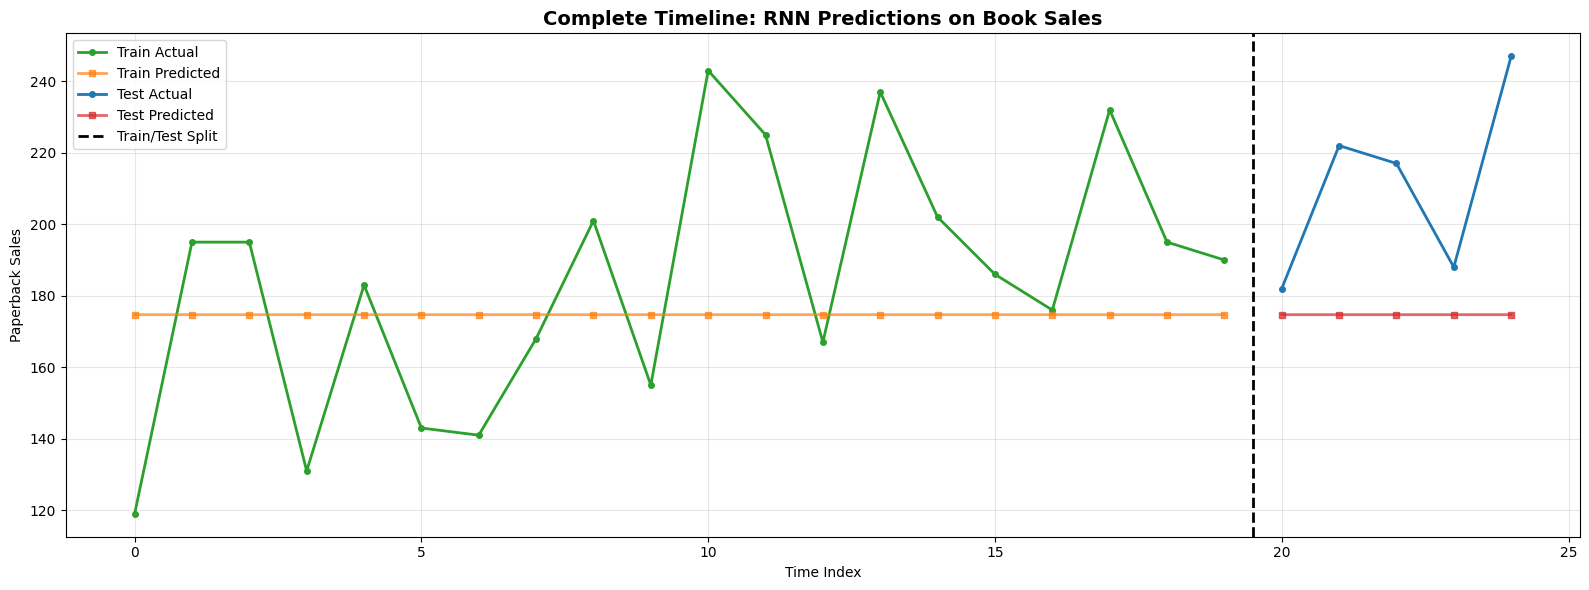

In [12]:
# Additional Visualization: Complete Timeline
fig, ax = plt.subplots(figsize=(16, 6))

# Combine train and test for full timeline
full_actual = np.concatenate([Y_train_actual, Y_test_actual])
full_predicted = np.concatenate([Y_train_pred_actual, Y_test_pred_actual])

# Plot complete timeline
train_indices = range(len(Y_train_actual))
test_indices = range(len(Y_train_actual), len(Y_train_actual) + len(Y_test_actual))

ax.plot(train_indices, Y_train_actual, color='#2ca02c', linewidth=2, marker='o', markersize=4, label='Train Actual')
ax.plot(train_indices, Y_train_pred_actual, color='#ff7f0e', linewidth=2, marker='s', markersize=4, alpha=0.7, label='Train Predicted')
ax.plot(test_indices, Y_test_actual, color='#1f77b4', linewidth=2, marker='o', markersize=4, label='Test Actual')
ax.plot(test_indices, Y_test_pred_actual, color='#d62728', linewidth=2, marker='s', markersize=4, alpha=0.7, label='Test Predicted')

# Add vertical line to separate train and test
ax.axvline(x=len(Y_train_actual)-0.5, color='black', linestyle='--', linewidth=2, label='Train/Test Split')

ax.set_title('Complete Timeline: RNN Predictions on Book Sales', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Index')
ax.set_ylabel('Paperback Sales')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

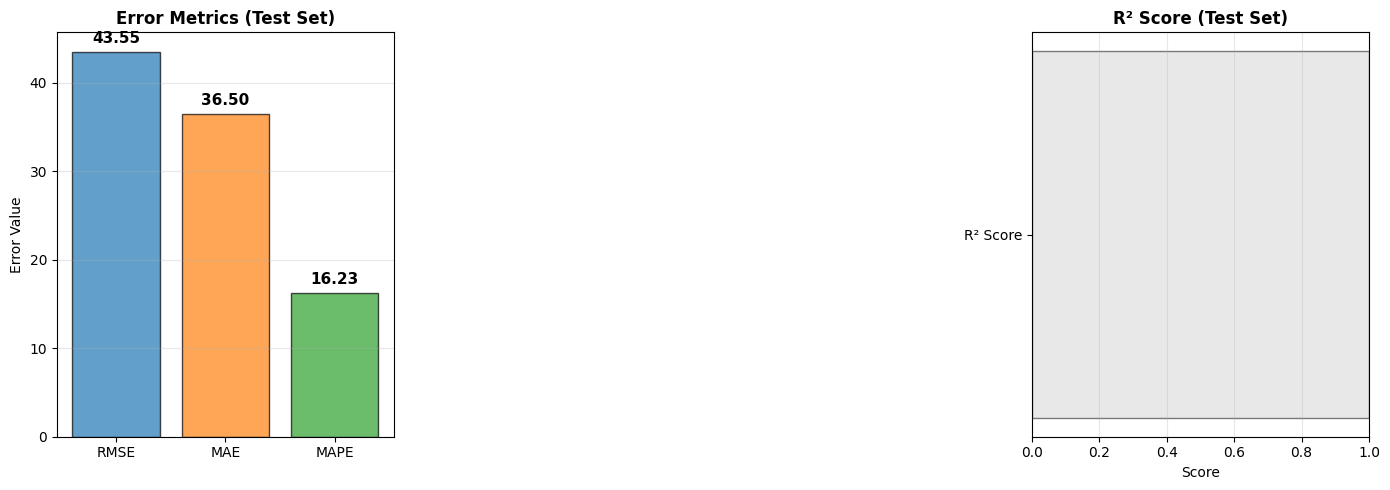


✓ Model Performance: R² = -2.3593, RMSE = 43.55


In [13]:
# Performance Metrics Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Metrics Bar Chart
metrics = ['RMSE', 'MAE', 'MAPE']
values = [rmse, mae, mape]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = axes[0].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Error Metrics (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error Value')
for i, v in enumerate(values):
    axes[0].text(i, v + 1, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. R² Score Gauge
axes[1].barh(['R² Score'], [r2], color='#d62728', alpha=0.7, edgecolor='black', height=0.3)
axes[1].barh(['R² Score'], [1-r2], left=[r2], color='lightgray', alpha=0.5, edgecolor='black', height=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_title('R² Score (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Score')
axes[1].text(r2/2, 0, f'{r2:.4f}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n✓ Model Performance: R² = {r2:.4f}, RMSE = {rmse:.2f}")